In [1]:
import re
import os
import pandas as pd
import numpy as np
import csv
import jieba
import jieba.posseg as pseg

In [2]:
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
 
# spacy for lemmatization
import spacy
 
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
#读入数据
group_3 = pd.read_csv('D:\my research\group\group_3\group_3.csv',encoding='utf-8')
group_3.columns = ['0','content','date','time','user_id']
group_3 = group_3.drop(columns='0')
#group_1_del = group_1_del.dropna(axis=0, how='any')
#group_1 = group_1[0:100]
group_3.head()

,content,date,time,user_id
0,好的，我知道了～拜拜啦您～不懂事的小屁孩,2022-08-01,2022-08-01 16:49:32,1000347570
1,太开心啦，一次成功！小朋友太爱吃了～为娘很欣慰,2022-07-31,2022-07-31 11:27:09,1000347570
2,南汇好朋友的再次投喂～🍇葡萄太好吃了吧！,2022-07-30,2022-07-30 20:16:07,1000347570
3,周五ootd9.9的F21的T恤真香～我真是省钱小能手包包也是同事送的,2022-07-29,2022-07-29 08:59:32,1000347570
4,小可爱太乖了～以后妈妈多带你出门哈 上海·上海月星环球港,2022-07-24,2022-07-24 13:32:46,1000347570


In [4]:
def clean(text):
    text = re.sub(r"(回复)?(//)?\s*@\S*?\s*(:| |$)", " ", text)  # 去除正文中的@和回复/转发中的用户名
    text = re.sub(r"\[\S+\]", "", text)      # 去除表情符号
    text = re.sub(r"#\S+#", "", text)      # 保留话题内容
    URL_REGEX = re.compile(
        r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))',
        re.IGNORECASE)
    text = re.sub(URL_REGEX, "", text)       # 去除网址
    text = text.replace('转发微博','') # 去除无意义的词语
    text = text.replace('网页链接','')
    text = text.replace('的微博视频','')
    text = text.replace('妞妞端午花草','')
    text = text.replace('bluepoint2006','')
    text = text.replace('上海','')
    text = re.sub(r"\s+", " ", text) # 合并正文中过多的空格
    return text.strip()

In [5]:
count = []
for i in group_3['content']:
    line_u = str(i)
    line_uu = clean(line_u)
    count.append(line_uu)    

In [6]:
res = list ( filter ( None , count))

In [7]:
res

['好的，我知道了～拜拜啦您～不懂事的小屁孩',
 '太开心啦，一次成功！小朋友太爱吃了～为娘很欣慰',
 '南汇好朋友的再次投喂～🍇葡萄太好吃了吧！',
 '周五ootd9.9的F21的T恤真香～我真是省钱小能手包包也是同事送的',
 '小可爱太乖了～以后妈妈多带你出门哈 ·月星环球港',
 '今天穿了幸运色～🟠',
 '太快乐了～工作终于如我所愿了～',
 '今天的快乐是螺蛳粉给的～还有同事的manner抹茶冰淇淋～',
 '🍊妈妈也会想妈妈👩我已经三年没有见过我爸爸了👨',
 '好久不做越南春卷～就是备菜有点累～',
 '出门又有人说我们是洋娃娃了好吧，摊牌了～我们是混血荷（河）兰（南） ·金桥国际商业广场',
 '711会员的一元气泡水真不错！我真是省钱小能手',
 '🐂♊️♏️♊️ ·小尝 GOP STORY 韩国料理',
 '两只双子座♊️👭',
 '🍊爸爸越来越会～',
 '🥩 ·西塔老太太泥炉烤肉(华润时代广场店)',
 '大杨浦的路，真的很需要耐心～🚗',
 '周五两杯水果茶的快乐～🥤',
 '带薪休假的快乐还有18天',
 '跟聂总的周一🍵',
 '四年前的今天～🌉库存📷怀念自由出行的日子～',
 '今年疫情封闭2个多月没吃到第一批南汇西瓜，没想到第二批8424🍉也那么给力！南汇的朋友下午3点亲自采摘，亲自驱车送到家～太幸福了！感恩～',
 'B&C蹭的生日福利～不用排队的快乐～ 我的虹口赵露思～ ·瑞虹天地太阳宫',
 '小朋友🍊第一次逛山姆 ·山姆会员商店(旗舰店)',
 '今天家门口的大学毕业典礼🎓羡慕年轻真好～如果时光倒流，我一定好好读书～',
 '新同事的小礼物🎁真阔气～还人手一个',
 '时隔两年～我终于来M了～哈哈哈哈，喝个新品🥤庆祝一下～老板没办法白送的不喝不行',
 '🍊爸爸除了不会生孩子，什么都会～做老公可能不是💯但是做爸爸绝对是超满分💯祝全世界父亲👨节日快乐🍾️🎉',
 '30岁前想要的都实现了未来只想一路陪着🍊你们一起实现你们的梦想～愿我们都健康平安～感恩🧡',
 '今天是我的生日06月16日，来祝福我吧~',
 '微博记录📝31岁的最后一天即将32打卡📷～太喜欢30➕的自己～',
 '奶妈功成身退了～谢谢♏️辣妈的鲜花😍',
 '12元一杯的瑞幸真香～',
 '打工人的周一～🍵',
 '解封后的第一次堂食 ·喜马拉雅美术

In [8]:
def cut(x):
    return [word for word, flag in pseg.cut(x) if flag in ['n','v','a','r','i']]

texts = [cut(a) for a in res]

Building prefix dict from the default dictionary ...
2022-11-11 21:51:15,661 : DEBUG : Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Administrator\AppData\Local\Temp\jieba.cache
2022-11-11 21:51:15,677 : DEBUG : Loading model from cache C:\Users\Administrator\AppData\Local\Temp\jieba.cache
Loading model cost 0.905 seconds.
2022-11-11 21:51:16,582 : DEBUG : Loading model cost 0.905 seconds.
Prefix dict has been built successfully.
2022-11-11 21:51:16,590 : DEBUG : Prefix dict has been built successfully.


In [9]:
text = list ( filter ( None ,texts))

In [10]:
text

[['好', '我', '知道', '您'],
 ['开心', '成功', '小朋友', '爱', '吃', '娘', '欣慰'],
 ['好', '朋友', '投', '喂', '葡萄', '好吃'],
 ['T恤', '我', '省钱', '小', '能手', '包包', '是', '同事', '送'],
 ['乖', '妈妈', '带', '你', '出门', '星', '环球'],
 ['穿'],
 ['快乐', '如我所愿'],
 ['快乐', '是', '螺蛳', '粉给', '还有', '同事', '抹', '茶'],
 ['妈妈', '会', '想', '妈妈', '我', '没有', '见', '我', '爸爸'],
 ['做', '春卷', '备菜', '有点累'],
 ['出门', '有人', '说', '我们', '是', '洋娃娃', '好', '摊牌', '我们', '是', '混血', '国际'],
 ['会员', '气泡', '水', '真不错', '我', '省钱', '小', '能手'],
 ['料理'],
 ['爸爸', '会'],
 ['泥炉', '烤肉', '时代广场', '店'],
 ['大', '路', '需要', '耐心'],
 ['水果', '茶', '快乐'],
 ['带薪休假', '快乐', '还有', '天'],
 ['库存', '怀念', '自由', '出行', '日子'],
 ['疫情', '封闭', '吃', '到', '那么', '力', '朋友', '采摘', '驱车', '送到', '幸福', '感恩'],
 ['蹭', '不用', '排队', '快乐', '我', '天地'],
 ['小朋友', '逛', '会员', '商店', '旗舰店'],
 ['大学', '毕业典礼', '羡慕', '年轻', '好', '时光倒流', '我', '读书'],
 ['新', '同事', '小', '礼物', '阔气', '人手'],
 ['时隔', '我', '来', '新品', '庆祝', '老板', '没', '办法', '不行'],
 ['爸爸',
  '不会',
  '孩子',
  '什么',
  '会',
  '做',
  '可能',
  '做',
  '爸爸',
  '是',
  '超',
  '

In [11]:
import gensim.downloader as api
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

In [12]:
dictionary = corpora.Dictionary(text)
corpus = [dictionary.doc2bow(tmp) for tmp in text]

In [13]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [14]:
# 困惑度的XY坐标
x_perplexity = [] 
y_perplexity = [] 
# 一致性的XY坐标
x_coherence = [] 
y_coherence = [] 
#id2word：就是上边构造的dictionary字典
#passes：模型的训练次数
for i in range(1, 31):     
    # 循环生成主题数为i的模型， passes代表模型训练次数，数据量太大了，搞小一点。     
    lda = gensim.models.ldamodel.LdaModel(corpus_tfidf, num_topics=i, id2word=dictionary, passes=10)     
    # 计算当前模型困惑度
    cur_perplexity = lda.log_perplexity(corpus_tfidf)     
    # 构造横纵坐标轴数据
    x_perplexity.append(i)
    y_perplexity.append(cur_perplexity) 
    # 计算一致性
    cv_tmp = CoherenceModel(model=lda, texts=text, dictionary=dictionary, coherence='c_v') 
    x_coherence.append(i) 
    y_coherence.append(cv_tmp.get_coherence()) 

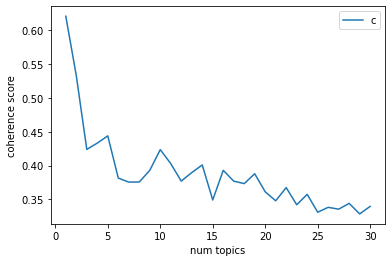

In [15]:
# 绘制一致性折线图 
plt.plot(x_coherence, y_coherence) 
plt.xlabel('num topics') 
plt.ylabel('coherence score') 
plt.legend(('coherence_values'), loc='best') 
plt.savefig('D:\my research\coherenceLine_1.jpg') 
plt.show() 

In [16]:
cohen = pd.DataFrame(y_coherence, x_coherence)
cohen.to_csv('D:\my research\group\coherence_3.csv',encoding="utf-8_sig") 

In [17]:
perp =  pd.DataFrame(y_perplexity, x_perplexity)
perp.to_csv('D:\my research\group\perplexity_3.csv',encoding="utf-8_sig") 

In [18]:
lda = gensim.models.ldamodel.LdaModel(corpus_tfidf, num_topics=5, id2word=dictionary, passes=10)

In [20]:
pyLDAvis.enable_notebook()
data = pyLDAvis.gensim.prepare(lda, corpus_tfidf, dictionary)
#让可视化可以在notebook内显示
pyLDAvis.show(data)

ValidationError: 
 * Not all rows (distributions) in topic_term_dists sum to 1.